# Time evolution resource counts

## Setup

In [1]:
import math
import pickle
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import scipy

import openfermion as of
from openfermionpyscf import run_pyscf, generate_molecular_hamiltonian
from openfermion.chem import geometry_from_pubchem, MolecularData

import cirq

import qiskit
import qiskit.qasm3
import qiskit_ibm_runtime
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import LieTrotter, SuzukiTrotter

### Grouping algorithms

In [2]:
# This code from https://arxiv.org/abs/2312.11840.
def compute_blocks(qubits: Iterable[cirq.Qid], k: int) -> List[List[cirq.Qid]]:
    return [qubits[k * i : k * (i + 1)] for i in range(math.ceil(len(qubits) / k))]


def restrict_to(
    pauli: cirq.PauliString, qubits: Iterable[cirq.Qid]
) -> cirq.PauliString:
    """Returns the Pauli string restricted to the provided qubits.

    Args:
        pauli: A Pauli string.
        qubits: A set of qubits.

    Returns:
        The provided Pauli string acting only on the provided qubits.
        Note: This could potentially be empty (identity).
    """
    return cirq.PauliString(p.on(q) for q, p in pauli.items() if q in qubits)


def commutes(pauli1: cirq.PauliString, pauli2: cirq.PauliString, blocks: List[List[cirq.Qid]]) -> bool:
    """Returns True if pauli1 k-commutes with pauli2, else False.

    Args:
        pauli1: A Pauli string.
        pauli2: A Pauli string.
        blocks: The block partitioning.
    """
    for block in blocks:
        if not cirq.commutes(restrict_to(pauli1, block), restrict_to(pauli2, block)):
            return False
    return True


def get_terms_ordered_by_abscoeff(ham: cirq.PauliSum) -> List[cirq.PauliString]:
    """Returns the terms of the PauliSum ordered by coefficient absolute value.

    Args:
        ham: A PauliSum.

    Returns:
        a list of PauliStrings sorted by the absolute value of their coefficient.
    """
    return sorted([term for term in ham], key=lambda x: abs(x.coefficient), reverse=True)


def get_si_sets(ham: cirq.PauliSum, k: int = 1) -> List[List[cirq.PauliString]]:
    """Returns grouping from the sorted insertion algorithm [https://quantum-journal.org/papers/q-2021-01-20-385/].

    Args:
        ham: The observable to group.
        k: The integer k in k-commutativity.
    """
    qubits = sorted(set(ham.qubits))
    blocks = compute_blocks(qubits, k)

    commuting_sets = []
    # terms = [term for term in ham]
    # np.random.shuffle(terms)
    terms = get_terms_ordered_by_abscoeff(ham)
    for pstring in terms:
        found_commuting_set = False

        for commset in commuting_sets:
            cant_add = False

            for pauli in commset:
                if not commutes(pstring, pauli, blocks):
                    cant_add = True
                    break

            if not cant_add:
                commset.append(pstring)
                found_commuting_set = True
                break

        if not found_commuting_set:
            commuting_sets.append([pstring])

    return commuting_sets

### Shout count metrics

In [3]:
def compute_rhat(groups: List[List[cirq.PauliString]]) -> float:
    """Computes that Rhat  metric from https://quantum-journal.org/papers/q-2021-01-20-385/.
    
    Args:
        groups: Groups of Paulis in the form [group1, group2, ...] where group1 = [pauli1, pauli2, ...], etc.
    """
    r_numerator = 0.0
    r_denominator = 0.0
    for group in groups:
        if isinstance(group, cirq.PauliSum):
            a_ij = sum([term.coefficient for term in group])
            r_numerator += abs(a_ij)
            r_denominator += np.sqrt(abs(a_ij) ** 2)
        else:
            a_ij = np.array([term.coefficient for term in group])
            group_sum = np.sum(np.abs(a_ij))
            group_sum_squares = np.sum(np.abs(a_ij) ** 2)
            r_numerator += group_sum
            r_denominator += np.sqrt(group_sum_squares)
    return (r_numerator / r_denominator) ** 2

### OpenFermion sucks

In [4]:
def get_qubits(hamiltonian: of.QubitOperator) -> set[int]:
    qubits = set()
    for p in hamiltonian.get_operators():
        for qubit, _ in list(p.terms.keys())[0]:
            qubits.add(qubit)
    return qubits

def get_num_qubits(hamiltonian: of.QubitOperator) -> int:
    return len(get_qubits(hamiltonian))


def preprocess_hamiltonian(
    hamiltonian: of.QubitOperator,
    drop_term_if = None,
) -> cirq.PauliSum:
    """Drop identity terms from the Hamiltonian and convert to Cirq format."""
    if drop_term_if is None:
        drop_term_if = []

    new = cirq.PauliSum()

    for term in hamiltonian.terms:
        add_term = True

        for drop_term in drop_term_if:
            if drop_term(term):
                add_term = False
                break

        if add_term:
            key = " ".join(pauli + str(index) for index, pauli in term)
            new += next(iter(
                of.transforms.qubit_operator_to_pauli_sum(
                    of.QubitOperator(key, hamiltonian.terms.get(term)
                )
            )))

    return new

### HamLib helper

In [5]:
import h5py


def read_openfermion_hdf5(fname_hdf5: str, key: str, optype=of.QubitOperator):
    """
    Read any openfermion operator object from HDF5 file at specified key.
    'optype' is the op class, can be of.QubitOperator or of.FermionOperator.
    """

    with h5py.File(fname_hdf5, 'r', libver='latest') as f:
        op = optype(f[key][()].decode("utf-8"))
    return op


def parse_through_hdf5(func):
    """
    Decorator function that iterates through an HDF5 file and performs
    the action specified by ‘ func ‘ on the internal and leaf nodes in the HDF5 file.
    """

    def wrapper (obj, path = '/', key = None) :
        if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
            for ky in obj.keys() :
                func(obj, path, key=ky, leaf = False)
                wrapper(obj = obj[ky], path = path + ky + ',', key = ky)
        elif type (obj) == h5py._hl.dataset.Dataset:
            func(obj, path, key = None, leaf = True)
    return wrapper


def get_hdf5_keys (fname_hdf5 : str ) :
    """ Get a list of keys to all datasets stored in the HDF5 file .
    Args
    ----
    fname_hdf5 ( str ) : full path where HDF5 file is stored
    """

    all_keys = []
    @parse_through_hdf5
    def action(obj, path = '/', key = None, leaf = False):
        if leaf is True :
            all_keys.append(path)

    with h5py.File(fname_hdf5, 'r') as f:
        action(f['/'])
    return all_keys

## Select molecule and load Hamiltonian

### From PubChem + OpenFermion

In [6]:
# Set parameters to make a simple molecule.
geometry = geometry_from_pubchem('water')
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Make molecule and print out a few interesting facts about it.
molecule = MolecularData(geometry, basis, multiplicity, charge)


mol = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
mol.save()
water = MolecularData(filename=molecule.filename)
hamiltonian = water.get_molecular_hamiltonian()
hamiltonian = of.get_fermion_operator(hamiltonian)
hamiltonian_openfermion = of.jordan_wigner(hamiltonian)
hamiltonian = preprocess_hamiltonian(hamiltonian_openfermion, drop_term_if=[lambda term: term == ()])  # Drop identity.

### From Norm and Wayne

In [7]:
# geometry = [
#     ("O", (0.0, 0.0, 0.1173)), 
#     ("H", (0.0, 0.7572, -0.4692)), 
#     ("H", (0.0, -0.7572, -0.4692))
# ]
# basis = "sto-3g"
# multiplicity = 1
# charge = 0

# hamiltonian = generate_molecular_hamiltonian(
#     geometry, basis, multiplicity, charge
# )

# # Convert to a FermionOperator
# hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)

# # Get the active space hamiltonian
# freeze_occ_spin_orbs = [0, 1, 2, 3, 4, 5]
# remove_vir_spin_orbs = []
# hamiltonian_ferm_op_active = of.transforms.freeze_orbitals(hamiltonian_ferm_op, freeze_occ_spin_orbs, remove_vir_spin_orbs)

# hamiltonian = hamiltonian_ferm_op_active
# hamiltonian = of.jordan_wigner(hamiltonian)
# hamiltonian = preprocess_hamiltonian(hamiltonian, drop_term_if=[lambda term: term == ()])  # Drop identity.

### From HamLib

In [8]:
# get_hdf5_keys("OH.hdf5")

In [9]:
# hamiltonian = read_openfermion_hdf5(
#     "OH.hdf5", "./ham_BK10"
# )
# hamiltonian = preprocess_hamiltonian(hamiltonian, drop_term_if=[lambda term: term == ()])  # Drop identity.


### Show statistics

In [10]:
nterms = len(hamiltonian)
nqubits = len(hamiltonian.qubits)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1389 term(s).


## Estimate number of CNOTs for first order Trotter

In [11]:
groups = get_si_sets(hamiltonian, k=nqubits)
len(groups)

59

In [12]:
print("# terms\t\tMin Weight\tAvg weight\tMax weight")
print("-" * 58)
for group in groups:
    weights = [len(pauli.qubits) for pauli in group]
    print(len(weights), "\t\t", np.min(weights), "\t\t", round(np.average(weights)), "\t\t\t", np.max(weights))

# terms		Min Weight	Avg weight	Max weight
----------------------------------------------------------
105 		 1 		 2 			 2
80 		 4 		 8 			 10
80 		 3 		 5 			 8
52 		 4 		 8 			 11
20 		 2 		 4 			 6
28 		 4 		 8 			 12
20 		 3 		 5 			 6
20 		 6 		 8 			 10
64 		 4 		 9 			 14
28 		 3 		 4 			 6
20 		 4 		 8 			 10
28 		 4 		 6 			 8
24 		 6 		 6 			 6
20 		 4 		 6 			 10
28 		 4 		 9 			 10
20 		 6 		 8 			 12
22 		 6 		 8 			 10
22 		 6 		 7 			 10
42 		 3 		 8 			 12
14 		 6 		 8 			 13
14 		 4 		 8 			 13
18 		 4 		 7 			 10
18 		 2 		 7 			 8
40 		 4 		 7 			 8
34 		 4 		 8 			 12
32 		 4 		 8 			 12
34 		 4 		 8 			 12
34 		 2 		 7 			 12
16 		 4 		 7 			 10
24 		 4 		 7 			 12
20 		 4 		 8 			 12
20 		 6 		 7 			 10
28 		 4 		 7 			 12
14 		 4 		 5 			 10
10 		 6 		 8 			 10
24 		 6 		 10 			 12
24 		 4 		 7 			 12
26 		 2 		 9 			 14
22 		 4 		 7 			 12
12 		 8 		 12 			 14
14 		 4 		 10 			 12
18 		 6 		 9 			 12
8 		 12 		 12 			 12
16 		 6 		 9 			 10
8 		 10 		 11 			 12
16

In [13]:
"""Estimate using grouping + diagonaliztion + exp(Z...Z) "ladder"."""
num_cnots: int = 0
for group in groups:
    num_cnots += nqubits ** 2  # It takes O(n^2) Clifford gates to diagonalize all terms in this group [https://arxiv.org/abs/quant-ph/0406196].
    for term in group:
        num_cnots += 2 * len(term.qubits)  # Using 2w CNOTs in a "ladder" and one exp(Z) gate on the bottom qubit. See https://arxiv.org/abs/2408.08265v3 Fig. 3.
    num_cnots += nqubits ** 2  # Rotating back to the Z basis (undoing the diagonal unitary).

num_cnots

42488

In [14]:
"""Crude estimate."""
num_cnots_crude: int = 0
for term in hamiltonian:
    num_cnots_crude += 2 ** (len(term.qubits) - 1)

num_cnots_crude

557352

In [15]:
# In an n-qubit circuit, at most n/2 CNOTs can fit in a layer.
min_depth = round(num_cnots / (len(hamiltonian.qubits) / 2))
min_depth

6070

### Qiskit's `PauliHedral` method

In [16]:
def cirq_pauli_sum_to_qiskit_pauli_op(pauli_sum: cirq.PauliSum) -> SparsePauliOp:
    cirq_pauli_to_str = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    qubits = hamiltonian.qubits
    terms = []
    coeffs = []
    for term in pauli_sum:
        string = ""
        for qubit in qubits:
            if qubit not in term:
                string += "I"
            else:
                string += cirq_pauli_to_str[term[qubit]]
        terms.append(string)
        assert np.isclose(term.coefficient.imag, 0.0, atol=1e-7)
        coeffs.append(term.coefficient.real)
    return SparsePauliOp(terms, coeffs)

In [17]:
H = cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian)

In [18]:
# Following https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html.
order: int = 1
cx_structure = "chain"  # "fountain"
trotter_step = PauliEvolutionGate(H, time=1, synthesis=LieTrotter(cx_structure=cx_structure) if order == 1 else SuzukiTrotter(order, cx_structure=cx_structure))

circuit = qiskit.QuantumCircuit(H.num_qubits)
circuit.append(trotter_step, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

print(
    f"""
              Depth: {circuit.depth()}
         Gate count: {len(circuit)}
Nonlocal gate count: {circuit.num_nonlocal_gates()}
     Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)


              Depth: 21544
         Gate count: 29639
Nonlocal gate count: 16582
     Gate breakdown: CX: 16582, U2: 7752, U1: 5164, RZ: 101, RX: 20, H: 20



In [19]:
# circuit.draw(fold=-1)

### Compile

In [20]:
compiled = qiskit.transpile(
    circuit,
    optimization_level=3,
    basis_gates=["u3", "cx"]
)

In [21]:
print(
    f"""
              Depth: {compiled.depth()}
         Gate count: {len(compiled)}
Nonlocal gate count: {compiled.num_nonlocal_gates()}
     Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in compiled.count_ops().items()])}
"""
)


              Depth: 13310
         Gate count: 16679
Nonlocal gate count: 10307
     Gate breakdown: CX: 10307, U3: 6372



In [22]:
# compiled.draw(fold=-1)

### Compile to device

In [35]:
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()

In [36]:
compiled_fez = qiskit.transpile(
    compiled,
    backend=computer,
    optimization_level=3,
)

In [37]:
print(
    f"""
              Depth: {compiled_fez.depth()}
         Gate count: {len(compiled_fez)}
Nonlocal gate count: {compiled_fez.num_nonlocal_gates()}
     Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in compiled_fez.count_ops().items()])}
"""
)


              Depth: 62531
         Gate count: 113354
Nonlocal gate count: 16702
     Gate breakdown: RZ: 58384, SX: 35794, ECR: 16702, X: 2474



## Number of Trotter steps for chemical accuracy

See https://arxiv.org/abs/1912.08854.

In [27]:
error = np.sum(np.abs(H.coeffs))  # Loose error bound from https://arxiv.org/abs/1912.08854.

In [28]:
epsilon: float = 0.001  # mHa

In [29]:
nsteps = round(error / epsilon)
nsteps

71970

## VQE resources

### Gates

Read in VQE circuits.

In [30]:
circuit_vqe = qiskit.qasm3.loads(pickle.load(open("kyiv_circuit_h2o", "rb")))

print(
    f"""
              Depth: {circuit_vqe.depth()}
         Gate count: {len(circuit_vqe)}
Nonlocal gate count: {circuit_vqe.num_nonlocal_gates()}
     Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit_vqe.count_ops().items()])}
"""
)


              Depth: 1075
         Gate count: 2154
Nonlocal gate count: 303
     Gate breakdown: RZ: 1135, SX: 672, ECR: 303, X: 32, BARRIER: 12



## Number of circuits / shots

In [31]:
def to_groups_of(groups: List[List[cirq.PauliString]]) -> List[of.QubitOperator]:
    """Convert groups from List[List[cirq.PauliString]] to List[of.QubitOperator]."""
    maps = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    groups_of: List[of.QubitOperator] = []
    for group in groups:
        group_of = of.QubitOperator()

        for p in group:
            group_of += of.QubitOperator(" ".join([f"{maps[v]}{k.x}" for k, v in p._qubit_pauli_map.items()]), coefficient=p.coefficient)
        groups_of.append(group_of)

    return groups_of


def get_variance(qubop: of.QubitOperator, psi: np.ndarray):
    """Returns the variance ⟨psi|O^2|psi⟩ - ⟨psi|O|psi⟩^2 where O is the QubitOperator `qubop`."""
    op = of.linalg.get_sparse_operator(qubop, n_qubits=int(np.log2(len(psi))))
    opsq = op @ op

    mean = psi.conj().T @ (op @ psi)
    opsq_expect = psi.conj().T @ (opsq @ psi)
    return opsq_expect - mean ** 2


def compute_shots(groups: List[of.QubitOperator], psi: np.ndarray, epsilon: float) -> int:
    """Returns the shots required to compute the expectation value of the
    grouped operator with respect to the state psi to an accuracy epsilon.

    Args:
        groups: The grouping of the operator to compute the expectation value of. 
        psi: The state to compute the expectation value with respect to.
        epsilon: The desired error.
    """
    temp = 0.0
    for op in groups:
        var = get_variance(op, psi)
        temp += np.sqrt(var)

    temp = temp**2
    shotcounts = temp.real / epsilon ** 2

    return round(shotcounts.real)

In [32]:
eval, evec = scipy.sparse.linalg.eigsh(
    of.linalg.get_sparse_operator(hamiltonian_openfermion),
    k=1,
    which="SA"
)
evec = evec.flatten()

In [33]:
epsilons = [0.1, 0.01, 0.001]
kvals = [1, 2, nqubits // 2, nqubits]

all_shots = []
for k in kvals:
    groups = get_si_sets(hamiltonian, k=k)
    groups_of = to_groups_of(groups)
    base_shots = compute_shots(groups_of, evec, epsilon=1)
    shots = [base_shots / epsilon ** 2 for epsilon in epsilons]
    all_shots.append(shots)
    print(all_shots)

[[2399.9999999999995, 240000.0, 24000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0], [1499.9999999999998, 150000.0, 15000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0], [1499.9999999999998, 150000.0, 15000000.0], [799.9999999999999, 80000.0, 8000000.0]]


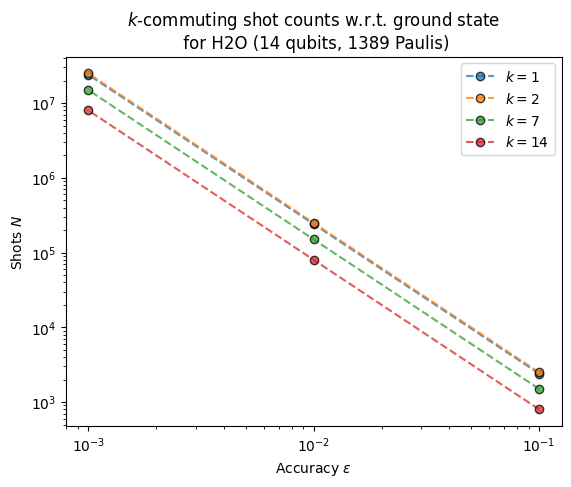

In [34]:
for kval, shots in zip(kvals, all_shots):
    plt.loglog(epsilons, shots, "--o", alpha=0.75, mec="black", label=f"$k = {kval}$")

plt.legend()
plt.xlabel("Accuracy $\epsilon$")
plt.ylabel("Shots $N$")
plt.title(f"$k$-commuting shot counts w.r.t. ground state\n for H2O ({nqubits} qubits, {nterms} Paulis)");